start with importing everything, the info for the professors i want

In [ ]:
pip install planetterp

In [ ]:
#usual stuff from earlier projects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, load_dataset, DatasetDict
import sklearn
import torch
import random

import planetterp

#play arouond w profs
yoon = planetterp.professor(name="Ilchul Yoon", reviews="true")
kauffman = planetterp.professor(name="Christopher Kauffman", reviews="true")
fawzi = planetterp.professor(name = "Fawzi Emad", reviews= "true")
justin = planetterp.professor(name = "Justin Wyss-Gallifent", reviews= "true")
ebrahimian = planetterp.professor(name = "Roohollah Ebrahimian", reviews= "true")
kruskal = planetterp.professor(name = "Clyde Kruskal", reviews= "true")
song = planetterp.professor(name = "Shin Song", reviews= "true")

#getting the info properly yayayayy
# print(yoon)
# for review in yoon['reviews']:
#   print(review)


{'courses': ['BMGT302', 'BMGT402', 'CMSC106', 'CMSC131', 'CMSC122', 'CMSC411', 'CMSC389N', 'CMSC216', 'CMSC132', 'CMSC411', 'CMSC106', 'CMSC216', 'CMSC216', 'CMSC411', 'CMSC335', 'CMSC411', 'CMSC411', 'CMSC216', 'CMSC411', 'CMSC106', 'CMSC216', 'CMSC411', 'CMSC131', 'CMSC411', 'CMSC216', 'CMSC411'], 'average_rating': 2.2768, 'type': 'professor', 'reviews': [{'professor': 'Ilchul Yoon', 'course': 'CMSC131', 'review': "Really nice guy. Co-taught CMSC131 with Dr. Pugh this past semester and didn't lecture much but still was active in teaching the course. I'm confident he'll do a great job teaching 131 next semester.", 'rating': 5, 'expected_grade': '', 'created': '2017-12-28T20:23:02Z'}, {'professor': 'Ilchul Yoon', 'course': 'CMSC131', 'review': "Really, super nice. He's very excited and enthusiastic about teaching which is great.", 'rating': 5, 'expected_grade': '', 'created': '2018-05-10T01:23:33Z'}, {'professor': 'Ilchul Yoon', 'course': 'CMSC131', 'review': 'I work for him and he car

merge these teachers together into a large dataset -> i wonder if it'll be difficult bc ebrahimians super positive vs. yoon who's super negative (or is the wide range of reviews more useful?)

In [ ]:
#merge profs together
#all_profs = [yoon, kauffman, fawzi, justin, ebrahimian]
all_profs = [yoon, fawzi, ebrahimian, kruskal, song]
reviews_ = []

for prof in all_profs:
    reviews_.extend(prof['reviews'])

#narrow down to only rating + text_review
reviews = [{'rating': review['rating'], 'review': review['review']} for review in reviews_]

#turn into dataset to use properly w huggingface
reviews = Dataset.from_list(reviews)

#because of some error when its 1-5 thank you random video on youtube
reviews = reviews.map(lambda x: {"rating": x["rating"] - 1})

# for review in reviews:
#    print(review)

Map:   0%|          | 0/724 [00:00<?, ? examples/s]

first just observe the data for these professors? + prep it to train/test? (like the split train test) -> also later maybe test w a brand new prof?

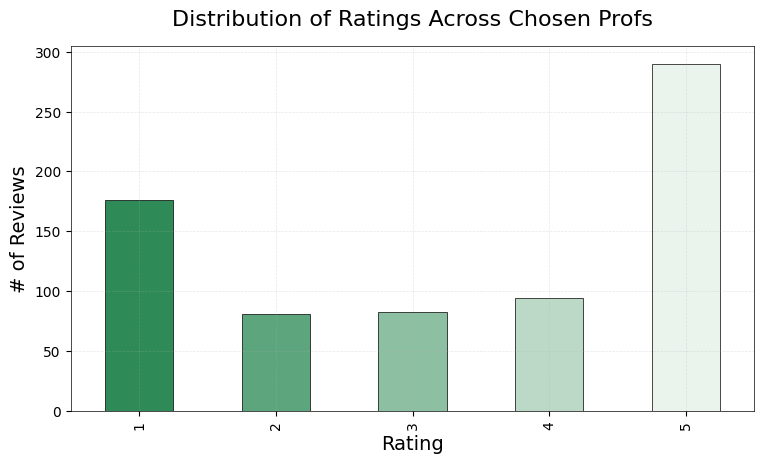

In [ ]:
# dist of overall ratings im working w (class imbalances?)

visualize_ratings = pd.DataFrame(reviews)

#change back to 1-5 j for this
visualize_ratings['rating'] = visualize_ratings['rating'] + 1

rating_counts = visualize_ratings['rating'].value_counts().sort_index()
plt.figure(figsize=(8, 5))

palette = sns.light_palette("seagreen", n_colors=len(rating_counts), reverse=True)

rating_counts.plot(kind='bar', color=palette, edgecolor='black', linewidth=0.5)

for spine in plt.gca().spines.values():
    spine.set_linewidth(0.5)

plt.xlabel('Rating', fontsize=14)
plt.ylabel('# of Reviews', fontsize=14)
plt.title('Distribution of Ratings Across Chosen Profs', fontsize=16, pad=15)
plt.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
plt.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout(pad=2.0)
plt.show()


#original professor combo has SEVERE class imbalance -> is this why my accuracy is high?


In [ ]:
# play around with split at some point, rn 80/20
split = reviews.train_test_split(test_size=0.2, seed=42) #why is seed = 42 everywhere

setting up the actual training

ideas:
- cased vs uncased
- if including the prof vs only looking at rating + text made a difference in the transformers ability to guess the rating
they're likely to get?
- same with like expected grade, etc. gonna start with only the review and the rating
- just doing different models lol
- thinky thinky
- showing not only accuracy but precision and recall too? let's me see exactly where the inaccuracies were

In [ ]:
#tokenize (preprocessing)
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
#tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

#just do cased rn, do uncased if there's time
def tokenize(examples):
    return tokenizer(examples["review"], padding="max_length", truncation=True)

#tokenize them seperately, train only on the training token
training_token = split['train'].map(tokenize, batched=True)
testing_token = split['test'].map(tokenize, batched=True)


In [ ]:
pip install evaluate

In [ ]:
import evaluate
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)

    #adding MAE
    mae = mean_absolute_error(labels + 1, preds + 1)

    acc = accuracy.compute(predictions=preds, references=labels)["accuracy"]

    # add more metrics to do analysis on precision/recall
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)


    return {"accuracy": acc, "mae": mae,
            "precision": precision,
            "recall": recall,
            "f1": f1,
    }



FINDING HYPERPARAMETERS
- Only finding with my original professr combo + bert cased
- To save time, use whichever parameters go on top for when i play around with professor combos and maybe use the uncased model too?
- Mild adjustments is prob fine for playing around lol

In [ ]:
#ok actually training now following instructions from huggingface

#for finetuning: do grid eval?
"""
- epochs 2 - 5 (anymore and its overfitting iirc)
- batch size 8, 12, 16, 20, 32 idk
- learning rate 1e-5, 2e-5, 3e-5, 5e-5
"""

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

#fixing small issue for some reason only works if its label
training_token = training_token.rename_column("rating", "labels")
testing_token  = testing_token.rename_column("rating", "labels")

training_token.set_format("torch", columns=["input_ids", "attention_mask", "token_type_ids", "labels"])
testing_token.set_format("torch", columns=["input_ids", "attention_mask", "token_type_ids", "labels"])

# model = AutoModelForSequenceClassification.from_pretrained(
#     "google-bert/bert-base-cased",
#     num_labels=5
# )

# #copied from huggingface
# training_args = TrainingArguments(
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=2,
#     weight_decay=0.01,
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True,
#     report_to="none",
#     seed=42
# )

# #consider later -> warmup steps

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=training_token,
#     eval_dataset=testing_token,
#     compute_metrics=compute_metrics,
#     processing_class=tokenizer,
# )

# trainer.train()

# now redo so that i can do grid search and find the best version

In [ ]:
# make grid of everything i wanna test
grid = {
    "learning_rate": [1e-5, 2e-5, 3e-5],
    "batch_size": [8, 16],
    "epochs": [2, 3, 4]
}

def repeat (learn_r, batch, epochs):
  model = AutoModelForSequenceClassification.from_pretrained(
      "google-bert/bert-base-cased",
      #"google-bert/bert-base-uncased",
      num_labels=5
  )

  training_args = TrainingArguments(
      learning_rate=learn_r,
      per_device_train_batch_size=batch,
      per_device_eval_batch_size=batch,
      num_train_epochs=epochs,
      weight_decay=0.01,
      eval_strategy="epoch",
      save_strategy="no",
      report_to="none",
      seed=42
  )

  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=training_token,
      eval_dataset=testing_token,
      compute_metrics=compute_metrics,
      processing_class=tokenizer,
  )

  trainer.train()

  #when i want to look closer at what was right/wrong
  return trainer

  #for the grid search
  # metrics = trainer.evaluate()
  # return metrics


#actually make the loop
# results = []

# for learn_r in grid["learning_rate"]:
#   for batch in grid["batch_size"]:
#     for epochs in grid["epochs"]:
#       metric = repeat(learn_r, batch, epochs)

#       results.append({
#           "learning_rate": learn_r,
#           "batch_size": batch,
#           "epochs": epochs,
#           "accuracy": metric["eval_accuracy"],
#           "mae": metric["eval_mae"]
#       })

# print(results)



In [ ]:
#grid search results -> use the top ones to try different professor combos + the case vs uncased even maybe
#probably not the best practice but we have limited time lolz

results_og = [
    {'learning_rate': 1e-05, 'batch_size': 8, 'epochs': 2, 'accuracy': 0.6395939086294417, 'mae': 0.8324873096446781},
    {'learning_rate': 1e-05, 'batch_size': 8, 'epochs': 3, 'accuracy': 0.7157360406091371, 'mae': 0.5279187817258884},
    {'learning_rate': 1e-05, 'batch_size': 8, 'epochs': 4, 'accuracy': 0.7055837563451777, 'mae': 0.5431472081218274},
    {'learning_rate': 1e-05, 'batch_size': 16, 'epochs': 2, 'accuracy': 0.6649746192893401, 'mae': 0.7512690355329955},
    {'learning_rate': 1e-05, 'batch_size': 16, 'epochs': 3, 'accuracy': 0.5583756345177665, 'mae': 1.1421319796954315},
    {'learning_rate': 1e-05, 'batch_size': 16, 'epochs': 4, 'accuracy': 0.6903553299492385, 'mae': 0.6091370558375635},
    {'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 2, 'accuracy': 0.7288121827411168, 'mae': 0.4873096446700508},
    {'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 3, 'accuracy': 0.7461928934010152, 'mae': 0.4060913705583756},
    {'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 4, 'accuracy': 0.7309644670050761, 'mae': 0.4467005076142132},
    {'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 2, 'accuracy': 0.7106598984771574, 'mae': 0.5482233502538071},
    {'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 3, 'accuracy': 0.6954314720812182, 'mae': 0.5786802030456852},
    {'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 4, 'accuracy': 0.7055837563451777, 'mae': 0.5076142131979695},
    {'learning_rate': 3e-05, 'batch_size': 8, 'epochs': 2, 'accuracy': 0.7288121827411168, 'mae': 0.4365482233502538},
    {'learning_rate': 3e-05, 'batch_size': 8, 'epochs': 3, 'accuracy': 0.7411167512690355, 'mae': 0.4060913705583756},
    {'learning_rate': 3e-05, 'batch_size': 8, 'epochs': 4, 'accuracy': 0.7157360406091371, 'mae': 0.4010152284263959},
    {'learning_rate': 3e-05, 'batch_size': 16, 'epochs': 2, 'accuracy': 0.7258883248730964, 'mae': 0.5126903553299492},
    {'learning_rate': 3e-05, 'batch_size': 16, 'epochs': 3, 'accuracy': 0.6548223350253807, 'mae': 0.7563451776649747},
    {'learning_rate': 3e-05, 'batch_size': 16, 'epochs': 4, 'accuracy': 0.7360406091370558, 'mae': 0.4010152284263959}
]

#new profs that are "more balanced"
results = [
    {'learning_rate': 1e-05, 'batch_size': 8, 'epochs': 2, 'accuracy': 0.5140845070422535, 'mae': 1.1056338028169015},
    {'learning_rate': 1e-05, 'batch_size': 8, 'epochs': 3, 'accuracy': 0.5633802816901409, 'mae': 0.8591549295774648},
    {'learning_rate': 1e-05, 'batch_size': 8, 'epochs': 4, 'accuracy': 0.6197183098591549, 'mae': 0.5915492957746479},
    {'learning_rate': 1e-05, 'batch_size': 16, 'epochs': 2, 'accuracy': 0.4225352112676056, 'mae': 1.5704225352112675},
    {'learning_rate': 1e-05, 'batch_size': 16, 'epochs': 3, 'accuracy': 0.4647887323943662, 'mae': 1.323943661971831},
    {'learning_rate': 1e-05, 'batch_size': 16, 'epochs': 4, 'accuracy': 0.5563380281690141, 'mae': 0.9647887323943662},
    {'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 2, 'accuracy': 0.6690140845070423, 'mae': 0.5352112676056338},
    {'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 3, 'accuracy': 0.6056338028169014, 'mae': 0.5422535211267606},
    {'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 4, 'accuracy': 0.6267605633802817, 'mae': 0.5633802816901409},
    {'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 2, 'accuracy': 0.5845070422535211, 'mae': 0.7253521126760564},
    {'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 3, 'accuracy': 0.5563380281690141, 'mae': 0.7605633802816901},
    {'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 4, 'accuracy': 0.647887323943662, 'mae': 0.5352112676056338},
    {'learning_rate': 3e-05, 'batch_size': 8, 'epochs': 2, 'accuracy': 0.6338028169014085, 'mae': 0.5211267605633803},
    {'learning_rate': 3e-05, 'batch_size': 8, 'epochs': 3, 'accuracy': 0.6267605633802817, 'mae': 0.5563380281690141},
    {'learning_rate': 3e-05, 'batch_size': 8, 'epochs': 4, 'accuracy': 0.6056338028169014, 'mae': 0.5422535211267606},
    {'learning_rate': 3e-05, 'batch_size': 16, 'epochs': 2, 'accuracy': 0.6338028169014085, 'mae': 0.5985915492957746},
    {'learning_rate': 3e-05, 'batch_size': 16, 'epochs': 3, 'accuracy': 0.6197183098591549, 'mae': 0.5774647887323944},
    {'learning_rate': 3e-05, 'batch_size': 16, 'epochs': 4, 'accuracy': 0.6901408450704225, 'mae': 0.4647887323943662}
]

#checking a second time because was getting some inconsistency when running individually w only the hyperparameters
results_second_check = [
    {'learning_rate': 1e-05, 'batch_size': 8, 'epochs': 2, 'accuracy': 0.36619718309859156, 'mae': 1.823943661971831},
    {'learning_rate': 1e-05, 'batch_size': 8, 'epochs': 3, 'accuracy': 0.5633802816901409, 'mae': 0.8591549295774648},
    {'learning_rate': 1e-05, 'batch_size': 8, 'epochs': 4, 'accuracy': 0.6197183098591549, 'mae': 0.5915492957746479},
    {'learning_rate': 1e-05, 'batch_size': 16, 'epochs': 2, 'accuracy': 0.4225352112676056, 'mae': 1.5704225352112675},
    {'learning_rate': 1e-05, 'batch_size': 16, 'epochs': 3, 'accuracy': 0.4647887323943662, 'mae': 1.323943661971831},
    {'learning_rate': 1e-05, 'batch_size': 16, 'epochs': 4, 'accuracy': 0.5563380281690141, 'mae': 0.9647887323943662},
    {'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 2, 'accuracy': 0.6690140845070423, 'mae': 0.5352112676056338},
    {'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 3, 'accuracy': 0.6056338028169014, 'mae': 0.5422535211267606},
    {'learning_rate': 2e-05, 'batch_size': 8, 'epochs': 4, 'accuracy': 0.6267605633802817, 'mae': 0.5633802816901409},
    {'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 2, 'accuracy': 0.5845070422535211, 'mae': 0.7253521126760564},
    {'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 3, 'accuracy': 0.5563380281690141, 'mae': 0.7605633802816901},
    {'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 4, 'accuracy': 0.647887323943662, 'mae': 0.5352112676056338},
    {'learning_rate': 3e-05, 'batch_size': 8, 'epochs': 2, 'accuracy': 0.6338028169014085, 'mae': 0.5211267605633803},
    {'learning_rate': 3e-05, 'batch_size': 8, 'epochs': 3, 'accuracy': 0.6267605633802817, 'mae': 0.5563380281690141},
    {'learning_rate': 3e-05, 'batch_size': 8, 'epochs': 4, 'accuracy': 0.6056338028169014, 'mae': 0.5422535211267606},
    {'learning_rate': 3e-05, 'batch_size': 16, 'epochs': 2, 'accuracy': 0.6338028169014085, 'mae': 0.5985915492957746},
    {'learning_rate': 3e-05, 'batch_size': 16, 'epochs': 3, 'accuracy': 0.6197183098591549, 'mae': 0.5774647887323944},
    {'learning_rate': 3e-05, 'batch_size': 16, 'epochs': 4, 'accuracy': 0.6901408450704225, 'mae': 0.4647887323943662}]

results_df = pd.DataFrame(results_second_check)

In [ ]:
#ai generated**

def plot_top_configs(results_df):
    plt.rcParams["font.family"] = "DejaVu Sans"

    # Sort by accuracy (descending)
    top = results_df.sort_values("accuracy", ascending=False).copy()


    # Cleaner labels: LR • BS • Epochs
    top['label'] = top.apply(
        lambda row: f"{row.learning_rate} • {row.batch_size} • {row.epochs}",
        axis=1,
    )

    plt.figure(figsize=(8, 7))

    # Color-blind friendly palette
    palette = sns.light_palette("seagreen", n_colors=len(top), reverse=True)

    ax = sns.barplot(
        data=top,
        y="label",
        x="accuracy",
        palette=palette,
        edgecolor="black",
        linewidth=0.5
    )

    ax.tick_params(axis='y', pad=1)

    for spine in ax.spines.values():
      spine.set_linewidth(0.5)

    # Add accuracy labels to bars
    for p in ax.patches:
        ax.text(
            p.get_width() + 0.01,  # spacing from bar
            p.get_y() + p.get_height()/2,
            f"{p.get_width():.3f}",
            va="center",
            fontsize=10
        )

    # Titles + labels
    plt.title("Grid Search: Best Hyperparameters", fontsize=18, pad=15, loc="left")
    plt.xlabel("Accuracy", fontsize=14)
    plt.ylabel("LR • Batch • Epochs", fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)

    # Limit + grid
    plt.xlim(0.0, 1.0)
    plt.grid(axis="x", linestyle="--", alpha=0.3, linewidth=0.5)

    plt.tight_layout(pad=2.0)
    plt.show()


plot_top_configs(results_df)


PLAY AROUND W PROFS: Just realized huge class imabalance w original dataset

best parameter combos from grid search
- 2e-05 or 3e-05 for learning rate
- mostly batch size 8
- 3 maybe 4 epochs

REDO W MORE BALANCED PROFS:
- 3e-05
- batch size 16
- 4 epochs


can keep playing around w it:

In [ ]:
# #running it individually

# def set_seed(seed=42):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# set_seed(42)

# model = AutoModelForSequenceClassification.from_pretrained(
#     "google-bert/bert-base-cased",
#     num_labels=5
# )

# training_args = TrainingArguments(
#     learning_rate=3e-05,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=4,
#     weight_decay=0.01,
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     report_to="none",
#     dataloader_num_workers=0,
#     seed=42
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=training_token,
#     eval_dataset=testing_token,
#     compute_metrics=compute_metrics,
#     processing_class=tokenizer,
# )

# trainer.train()


#NOT GETTING VERY CLOSE RESULTS EVEN W HYPERPARAMETERS -> test again
#tested again and it still sucks, just call the repeat function to use the exact same model ig

metrics = repeat(3e-05, 8, 4)
print(metrics)


# #need to calc precision/recall not j accuracy i think, don't want it to be accurate only for 5s. may need more epochs for the more 1s im guessing

now do some more with precision/recall, do a confusion matrix with the ratings

In [ ]:
##MAKE SURE REPEAT FUNCTION RETURNS THE TRAINER AND NOT THE STATS WHEN I CALL THIS!!!!
from sklearn.metrics import classification_report, confusion_matrix

trainer = repeat(3e-05, 16, 4) #changed the function to return the trainer instead rn

#predictions
predictions = trainer.predict(testing_token) #the actual predictions
prediction_ratings = predictions.predictions.argmax(-1) #getting the most likely one
true_ratings = predictions.label_ids

# classification report
print("classification report")
print(classification_report(true_ratings, prediction_ratings,
                          target_names=['1 stars', '2 stars',
                                       '3 stars', '4 stars',
                                       '5 stars']))

# Confusion matrix
print("confusion matrix")
cm = confusion_matrix(true_ratings, prediction_ratings)
cm_df = pd.DataFrame(cm,
                     index=['true 1', 'true 2', 'true 3', 'true 4', 'true 5'],
                     columns=['pred 1', 'pred 2', 'pred 3', 'pred 4', 'pred 5'])
print(cm_df)

In [ ]:
#ai generated

def plot_confusion_matrix(cm_df):
    plt.rcParams["font.family"] = "DejaVu Sans"

    plt.figure(figsize=(7.5, 6.2))

    # green-ish palette
    cmap = sns.light_palette("seagreen", as_cmap=True)

    ax = sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        cmap=cmap,
        linewidths=0,
        linecolor="black",
        cbar=True,
        annot_kws={"size": 11},
    )

    # labels
    ax.set_xlabel("Predicted", fontsize=14, labelpad=10)
    ax.set_ylabel("True", fontsize=14, labelpad=10)

    # rotate y tick labels sideways (vertical)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=90, fontsize=11)

    # x tick labels normal
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=11)

    # cleaner border
    for spine in ax.spines.values():
        spine.set_linewidth(0)

    # more spacing on right side
    plt.tight_layout(pad=3.0)

    plt.title("Confusion Matrix", fontsize=20, pad=15)
    plt.show()

plot_confusion_matrix(cm_df)